In [1]:
from child import Child
import helper_functions
import sandia_stats
import time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import phasing_functions
from math import floor
%matplotlib inline

In [31]:
def sandia_t_test_snps(maternal_rd, paternal_rd, samp_size=10000, t_thres=25):
    mom_minus_samp_size = maternal_rd.size - samp_size
    if 0 > mom_minus_samp_size:
        print("Sample size is larger than total number of data points")
        return None
    else:
        # Step 1: Allocate an array that will store the t
        t_values = []
        # Step 2: Generate difference array between mom and dad
        diff_arr = (maternal_rd - paternal_rd).tolist()
        # Step 3: Calculate initial moments
        moments = sandia_stats.m1_m2_moment_generator(diff_arr[0:samp_size])
        # Step 4: Calculate t-statistic for first window
        t_values.append(abs(moments[0] / (moments[1] ** 0.5 / samp_size)))
        # Step 5: Calculate t-values for rest of positions
        counter2 = samp_size
        mom_update_func = sandia_stats.m1_m2_moment_updater
        for i in range(mom_minus_samp_size):
            moments = mom_update_func(moments, diff_arr[i], diff_arr[counter2], samp_size)
            counter2 += 1
            t_values.append(abs(moments[0] / (moments[1] ** 0.5 / samp_size)))
        # Step 6: See if any t-values exceed the t-value threshold
        index_of_mosaicism = next((i for i, elem in enumerate(t_values) if elem > t_thres), -1)
        if index_of_mosaicism != -1:
            # there is a t_value that exceeds the thresold, save the vcf position of the start
            index_start_of_mosaicism_vcf = index_of_mosaicism + samp_size - 1 if index_of_mosaicism != 0 else 0
            #vcf_pos_start_of_mosaicism = vcf_pos[index_start_of_mosaicism_vcf]
            # figure out the end point of mosaicism
            index_of_end_of_mosaicism = next(
                (i + index_of_mosaicism + 1 for i, elem in enumerate(t_values[index_of_mosaicism + 1:]) if
                 elem < t_thres), len(t_values) - 1)
            index_end_of_mosaicism_vcf = index_of_end_of_mosaicism + samp_size - 1
            #index_end_of_mosaicism_vcf = index_of_end_of_mosaicism + samp_size - 1 if index_of_end_of_mosaicism != len(t_values) - 1 else -1
            #vcf_pos_end_of_mosaicism = vcf_pos[index_end_of_mosaicism_vcf] 
            return [index_start_of_mosaicism_vcf, index_end_of_mosaicism_vcf]
        else:
            return None


def phasable_snp_determiner(chr_df, proband_name, father_name, mother_name):
    # first make temporary helper variables
    pos_final = []
    dad_rd_final = []
    mom_rd_final = []
    het_set = {"0/1", "1/0", "1|0", "0|1"}
    # iterate through every row
    for index, row in chr_df.iterrows():
        child_info = row[proband_name].split(':', 3)
        if child_info[0] in het_set:
            child_read_depths = child_info[1].split(',')
            child_rd_first = int(child_read_depths[0])
            child_rd_second = int(child_read_depths[1])
            if (4 < child_rd_first < 75) and (4 < child_rd_second < 75):
                # proband is a het; need to check the parents and check at least one is homozygous and if they are
                # both homozygous, not for same allele
                mom_line_info = row[mother_name].split(':', 2)
                dad_line_info = row[father_name].split(':', 2)
                mom_geno_count = Counter(mom_line_info[0])
                dad_geno_count = Counter(dad_line_info[0])
                if not (dad_geno_count['.'] or mom_geno_count['.']):
                    is_mom_hom_ref = 2 == mom_geno_count['0']
                    is_dad_hom_ref = 2 == dad_geno_count['0']
                    is_mom_hom_var = 2 == mom_geno_count['1']
                    is_dad_hom_var = 2 == dad_geno_count['1']
                    is_dad_het = 3 == len(dad_geno_count)
                    is_mom_het = 3 == len(mom_geno_count)
                    if not ((is_dad_het and is_mom_het) or
                            (is_mom_hom_ref and is_dad_hom_ref) or (
                                    is_mom_hom_var and is_dad_hom_var)):
                        # save the position number and then the read depth for the child
                        pos_final.append(row['POS'])
                        # case 1: Dad is hom var and mom is hom ref
                        if is_dad_hom_var and is_mom_hom_ref:
                            if child_info[0][0] == '1':
                                dad_rd_final.append(child_rd_first)
                                mom_rd_final.append(child_rd_second)
                            else:
                                dad_rd_final.append(child_rd_second)
                                mom_rd_final.append(child_rd_first)
                        # case 2: mom is hom var and dad is hom ref
                        elif is_mom_hom_var and is_dad_hom_ref:
                            if child_info[0][0] == '1':
                                dad_rd_final.append(child_rd_second)
                                mom_rd_final.append(child_rd_first)
                            else:
                                dad_rd_final.append(child_rd_first)
                                mom_rd_final.append(child_rd_second)
                        # case 3: Dad is a het
                        elif is_dad_het:
                            # if mom is hom ref
                            if is_mom_hom_ref:
                                if child_info[0][0] == '0':
                                    dad_rd_final.append(child_rd_second)
                                    mom_rd_final.append(child_rd_first)
                                else:
                                    dad_rd_final.append(child_rd_first)
                                    mom_rd_final.append(child_rd_second)
                            # if mom is hom var
                            else:
                                if child_info[0][0] == '1':
                                    dad_rd_final.append(child_rd_second)
                                    mom_rd_final.append(child_rd_first)
                                else:
                                    dad_rd_final.append(child_rd_first)
                                    mom_rd_final.append(child_rd_second)
                        # case 4: Mom is a het
                        else:
                            # if dad is hom ref
                            if is_dad_hom_ref:
                                if child_info[0][0] == '0':
                                    dad_rd_final.append(child_rd_first)
                                    mom_rd_final.append(child_rd_second)
                                else:
                                    dad_rd_final.append(child_rd_second)
                                    mom_rd_final.append(child_rd_first)
                            # if dad is hom var
                            else:
                                if child_info[0][0] == '1':
                                    dad_rd_final.append(child_rd_first)
                                    mom_rd_final.append(child_rd_second)
                                else:
                                    dad_rd_final.append(child_rd_second)
                                    mom_rd_final.append(child_rd_first)
    return pos_final, np.array(mom_rd_final), np.array(dad_rd_final)


def edge_detection(sample_size, estimated_start_index, estimated_end_index, paternal_rd_array, maternal_rd_array, vcf_pos):
    estimated_interval_length = estimated_end_index - estimated_start_index
    width_of_average = floor(estimated_interval_length / 2)
    fourth_up = floor(estimated_interval_length / 4)
    diff_arr = paternal_rd_array - maternal_rd_array
    print(diff_arr.size)
    height = diff_arr[estimated_start_index + fourth_up:estimated_start_index + fourth_up + width_of_average].mean()
    filter_width_one_side = floor(0.05 * sample_size)
    forward_filter = np.zeros(2 * filter_width_one_side)
    forward_filter[filter_width_one_side:] = height
    backward_filter = np.zeros(2 * filter_width_one_side)
    backward_filter[:filter_width_one_side] = height

    final_index = paternal_rd_array.size - 1
    is_mosaicism_to_the_end = estimated_end_index == final_index
    print('Final index is '+ str(final_index)+' and estimated_end_index is '+str(estimated_end_index))

    if not estimated_start_index and is_mosaicism_to_the_end:
        # estimated chromosome is mosaic
        return [vcf_pos[0], vcf_pos[final_index], 0, final_index, height]
    elif not (estimated_start_index or is_mosaicism_to_the_end):
        center_index = estimated_end_index - floor(0.5 * sample_size)
        filter_difference = [abs((diff_arr[
                                  center_index - filter_width_one_side + i: center_index + filter_width_one_side + i] - backward_filter).sum(
            dtype=float)) for i in range(sample_size)]
        min_val = min(filter_difference)
        return [vcf_pos[0], vcf_pos[center_index + filter_difference.index(min_val)], 0, center_index + filter_difference.index(min_val), height]
    elif estimated_start_index and is_mosaicism_to_the_end:
        center_index = estimated_start_index - floor(0.5 * sample_size)
        filter_difference = [abs((diff_arr[
                                  center_index - filter_width_one_side + i: center_index + filter_width_one_side + i] - forward_filter).sum(
            dtype=float)) for i in range(sample_size)]
        min_val = min(filter_difference)
        return [vcf_pos[center_index + filter_difference.index(min_val)], vcf_pos[final_index], center_index + filter_difference.index(min_val), final_index, height]
    else:
        center_start_index = estimated_start_index - floor(0.5 * sample_size)
        filter_start_difference = [abs((diff_arr[center_start_index - filter_width_one_side + i: center_start_index + filter_width_one_side + i] - forward_filter).sum(dtype=float)) for i in range(sample_size)]
        min_start_val = min(filter_start_difference)

        center_end_index = estimated_end_index - floor(0.5 * sample_size)
        
        
        
        filter_end_difference = [abs((diff_arr[center_end_index - filter_width_one_side + i:center_end_index + filter_width_one_side + i] - backward_filter).sum(dtype=float)) for i in range(sample_size)]
        min_end_val = min(filter_end_difference)

        return [vcf_pos[center_start_index + filter_start_difference.index(min_start_val)],vcf_pos[center_end_index + filter_end_difference.index(min_end_val)], center_start_index + filter_start_difference.index(min_start_val), center_end_index + filter_end_difference.index(min_end_val), height]


def runner(child_name, father_name, mother_name, chr_name, sample_size, t_threshold, SNP_df):
    # step 1: filter the SNP df by chromosome name
    chr_snp_df = helper_functions.chromosome_filter(SNP_df, chr_name)
    # step 2: do phasing and return results
    vcf_pos, maternal_rd, paternal_rd = phasable_snp_determiner(chr_snp_df, child_name, father_name, mother_name)
    mosaicism_initial_survey_results = sandia_t_test_snps(maternal_rd, paternal_rd, samp_size=sample_size, t_thres=t_threshold)
    return edge_detection(sample_size, mosaicism_initial_survey_results[0], mosaicism_initial_survey_results[1], paternal_rd, maternal_rd, vcf_pos) if mosaicism_initial_survey_results is not None else None

In [3]:
# Step 0: Read config file
with open('phasing_config_file.txt', 'r') as f:
    config_elem = {}
    for line in f:
        line_split = line.strip().split('\t')
        #print(line_split)
        config_elem[line_split[0]] = line_split[1]

In [4]:
print(config_elem)

{'PED_FILE': 'C:\\Users\\rodriguezah\\Desktop\\mosaicism_phasing\\UDP18111.ped', 'VCF_FILE': 'C:\\Users\\rodriguezah\\Desktop\\mosaicism_phasing\\cohort_joint_genotyped_UDP18111.vcf', 'SAMPLE_SIZE': '10000', 'T_THRES': '35', 'OUTPUT_FILE': 'C:\\Users\\rodriguezah\\Desktop\\mosaicism_phasing\\UDP18111_results_threshold_35_sample_size_10000_step_function_edge_detection.txt', 'PROBAND_NAME': 'UDP18111'}


In [5]:
# Step 1: Obtain names from ped file
names = helper_functions.ped_file_reader(config_elem["PED_FILE"])

In [6]:
# Step 2: Read in the vcf file
df = helper_functions.read_VCF(config_elem["VCF_FILE"], names)

C:\Users\rodriguezah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (0,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
# Step 3: obtain only high quality SNPs
SNP_df = helper_functions.SNP_filter(df)

In [8]:
# Step 4: Create child object for proband
proband = Child(config_elem["PROBAND_NAME"], names[0], names[1])

In [ ]:
# step 5: Generate results
start = time.time()
mosaicism_outcome = [phasing_functions.runner(config_elem["PROBAND_NAME"], names[0], names[1], chr_name, int(config_elem["SAMPLE_SIZE"]), float(config_elem["T_THRES"]), SNP_df) for chr_name in range(1,23)]
end = time.time()
print(str((end-start)/60) + " minutes")

In [9]:
# testing purposes
# step 1: filter the SNP df by chromosome name
chr_snp_df = helper_functions.chromosome_filter(SNP_df, 7)
# step 2: do phasing and return results
vcf_pos, maternal_rd, paternal_rd = phasable_snp_determiner(chr_snp_df, proband.name, proband.father_name, proband.mother_name)

In [10]:
mosaicism_initial_survey_results = sandia_t_test_snps(maternal_rd, paternal_rd, samp_size=int(config_elem["SAMPLE_SIZE"]), t_thres=float(config_elem["T_THRES"]))

In [32]:
if mosaicism_initial_survey_results is not None:
    final_results = edge_detection(int(config_elem["SAMPLE_SIZE"]), mosaicism_initial_survey_results[0], mosaicism_initial_survey_results[1], paternal_rd, maternal_rd, vcf_pos)

107148
Final index is 107147 and estimated_end_index is 107147


In [33]:
print(final_results)

[141529611, 159086440, 95301, 107147, -12.579831932773109]


In [34]:
diff_arr =  paternal_rd - maternal_rd

In [35]:
print(diff_arr.size)

107148


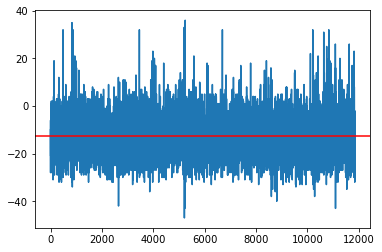

In [41]:
plt.plot(diff_arr[final_results[2]:final_results[3]])
plt.axhline(final_results[4], color='r')

In [ ]:
# step 6: write results to file
with open(config_elem["OUTPUT_FILE"], 'w') as output_file:
    output_file.write(" ".join(["Mosaicism results for", proband.name]))
    output_file.write("\n")
    output_file.write("\t".join(["chr_number", "VCF_start", "VCF_end"]))
    output_file.write("\n")
    for i, elem in enumerate(mosaicism_outcome):
        if elem is not None:
            output_file.write("\t".join([str(i + 1), str(elem[0]), str(elem[1])]))
            output_file.write("\n")

In [ ]:
# Verify results 
proband.phasable_snp_determiner(helper_functions.chromosome_filter(SNP_df, 7))
proband.t_test_snps(samp_size=int(config_elem["SAMPLE_SIZE"]), t_thres=float(config_elem["T_THRES"]))


In [ ]:
diff_arr = proband.dad_rd_array - proband.mom_rd_array
plt.plot(diff_arr)

In [ ]:
plt.plot(diff_arr[proband.index_diff_arr_start_of_mosaicism-3500:proband.index_diff_arr_end_of_mosaicism + 100000])

In [ ]:
proband.phasable_snp_determiner(helper_functions.chromosome_filter(SNP_df, 16))
proband.t_test_snps(samp_size=int(config_elem["SAMPLE_SIZE"]), t_thres=float(config_elem["T_THRES"]))

In [ ]:
diff_arr = proband.dad_rd_array - proband.mom_rd_array
plt.plot(diff_arr)

In [ ]:
plt.plot(diff_arr[proband.index_diff_arr_start_of_mosaicism:proband.index_diff_arr_end_of_mosaicism])
print(proband.index_diff_arr_start_of_mosaicism)
print(proband.index_diff_arr_end_of_mosaicism)

In [ ]:
plt.plot(proband.t_values)